## 1. Google Colab Settings:

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 122kB 15.5MB/s 
     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 163kB 17.6MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=c33eb1692025a8ca5e421f9fd2fa0fca7c39f1815319f8e82669bb47c3d9ebaa
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=9e051463fd965e9d4c995d1551ac12e8fe5d231f9fbe45bb25c899ba92d7b9ed
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=62cc

In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [3]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug 24 11:47:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/VAE_food')

## 2. Import packages and initalize model

In [ ]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Internal files
import config
import dataloader
import models
# from baseline import get_model, save_checkpoint

import math
import pandas
import os
import sys
import time
from collections import OrderedDict
import random

import wandb
import pandas as pd




noise file noisy_label_kv0_sim.txt generated with noise: 0



In [7]:
config.checkpoint

'vae_weights/vae_weights'

In [ ]:
config.id

'MLNT_normalization_sim_noise_0_noise_val'

In [ ]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50_fc(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model



def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if config.use_wandb == True:
        wandb.save(filename)

In [10]:
def get_feats():

    global df_relabel

    for step, (inputs, targets, path) in enumerate(train_loader):
        print(step)
        init_time = time.time()
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            # _, feats = pretrain_net(inputs, get_feat=True)
           feats, _ = pretrain_net.encode(inputs)
        #set a row of the dataframe
        
        new_row = {'batch':step, 'path':path, "targets":targets, "feats":feats}
        df_relabel = df_relabel.append(new_row,ignore_index=True)
    filename = config.drive_dir + '/data/' + 'targets_'+str(int(config.r*100))+'.csv'
    df_relabel.to_csv(filename, sep=';', index=False,header = False)
        

In [11]:
# # Checkpoint dir.
# record = open(config.drive_dir + '/checkpoint/' + config.checkpoint + '_test.txt', 'w')
# #ecord.write('noise_rate=%s\n' % config.noise_rate)
# record.flush()

# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
random.seed(config.seed)
# torch.cuda.set_device(config.gpuid)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
tch_net = get_model()
# pretrain_net = get_model()
test_net = get_model()

#GET PRETRAINED VAE MODEL
latent_size = 500

encoder = models.resnet34()
# encoder.eval()
decoder = models.decoder31()
# decoder.eval()
pretrain_net = models.VAE(encoder, decoder, latent_size)
# vae.eval()


print('| load pretrained net. from checkpoint...')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
pretrain_net.load_state_dict(checkpoint['state_dict'])

if use_cuda:
    net.cuda()
    tch_net.cuda()
    pretrain_net.cuda()
    test_net.cuda()
    cudnn.benchmark = True
pretrain_net.eval()

# for param in tch_net.parameters():
#     param.requires_grad = False
# for param in pretrain_net.parameters():
#     param.requires_grad = False

# # Instantiate a loss function.
# criterion = torch.nn.CrossEntropyLoss()
# consistent_criterion = torch.nn.KLDivLoss()

# # Instantiate an optimizer to train the model
# optimizer = torch.optim.SGD(
#     net.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

# print('\nTraining model')
# print('| Training Epochs = ' + str(config.num_epochs))
# print('| Initial Learning Rate = ' + str(config.lr))
# print('| Optimizer = ' + str(config.optimizer_type))




Model setup
| Building network: resnet50


/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/VAE_food/models/resnet_fc.py:115: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/VAE_food/models/resnet_fc.py:117: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/VAE_food/models/resnet_fc.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



| load pretrained net. from checkpoint...


VAE(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

# 3. Get Feats

In [20]:

#initialize dataframer
import pandas as pd
df_relabel = pd.DataFrame(columns = ["batch", "path", "targets","feats"])
get_feats()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

RuntimeError: ignored

In [ ]:
len(df_relabel.feats[0].tolist()[0])

In [ ]:
def path_to_list(lst):
  # lst = [s[s.find("(")+1:s.find(")")] for s in lst]
  lst = [x.replace(" ","") for x in lst]
  lst = [x.replace("'","") for x in lst]
  # lst = [x.split(",") for x in lst]
  return(lst)

In [ ]:
df_relabel.feats[0].cpu().numpy()[0]

In [ ]:
DF_FULL = pd.DataFrame()
for index, row in df_relabel.iterrows():
  df_iter = pd.DataFrame()
  df_iter["targets"] = row["targets"].cpu().numpy().tolist()
  df_iter["path"] = path_to_list(row["path"])
  df_iter["feats"] = row["feats"].cpu().numpy().tolist()
  DF_FULL = DF_FULL.append(df_iter.copy(),ignore_index=True)
  # print(type(row["targets_list")))
    # print(row['targets_list'], row['path_list'])

In [ ]:
DF_FULL

In [ ]:
DF_FULL["path"] = [x[72:] for x in DF_FULL.path]
DF_FULL

In [ ]:
filename = config.drive_dir + '/data/' + 'targets_full_vae'+str(int(config.r*100))+'.csv'
DF_FULL.to_csv(filename, sep=';', index=False,header = False)

Read again

In [ ]:
config.r = 0
import pandas as pd
filename = config.drive_dir + '/data/' + 'targets_full_'+str(int(config.r*100))+'.csv'
df_readed = pd.read_csv(filename, sep = ';', header = None)
df_readed.columns = ["targets", "path", "feats"]

In [ ]:
df_readed

,targets,path,feats
0,49,/images/sushi/794736.jpg,"[0.997857391834259, 0.7289683222770691, 0.1160..."
1,75,/images/club_sandwich/2438386.jpg,"[0.26388218998908997, 0.6876015663146973, 0.16..."
2,56,/images/macarons/2237879.jpg,"[0.2286073863506317, 0.06287682801485062, 0.07..."
3,95,/images/ravioli/3524550.jpg,"[0.3628886342048645, 0.10507843643426895, 0.01..."
4,17,/images/beet_salad/1384585.jpg,"[0.026511969044804573, 0.3093997538089752, 0.0..."
...,...,...,...
68170,90,/images/donuts/328708.jpg,"[0.24955493211746216, 0.308126837015152, 0.107..."
68171,41,/images/hamburger/1979079.jpg,"[0.05851959064602852, 0.5750203132629395, 0.23..."
68172,3,/images/apple_pie/934503.jpg,"[0.03205859661102295, 0.2530951201915741, 0.36..."
68173,67,/images/onion_rings/647116.jpg,"[0.12448088079690933, 0.7858483195304871, 0.16..."


In [ ]:
DF_FULL = df_readed.copy()

In [ ]:
import numpy as np
DF_FULL["feats"] = [np.array([float(y) for y in x.replace("[","").replace("]","").replace(" ","").split(",")]) for x in DF_FULL.feats]

In [ ]:
DF_FULL.feats

In [ ]:
import numpy as np
# df_X = DF_FULL[(DF_FULL.targets == 1) | (DF_FULL.targets == 2) | (DF_FULL.targets == 3) | (DF_FULL.targets == 4) ]["feats"]
df_X = DF_FULL.feats
feats = np.array([np.array(x) for x in np.array(df_X)   ])
feats

array([[0.99785739, 0.72896832, 0.11608297, ..., 0.05997687, 0.03486833,
        0.70309228],
       [0.26388219, 0.68760157, 0.16837685, ..., 0.03401176, 0.17732531,
        0.00700795],
       [0.22860739, 0.06287683, 0.07618032, ..., 0.03480599, 0.7233144 ,
        0.61589694],
       ...,
       [0.0320586 , 0.25309512, 0.36155748, ..., 0.88905025, 0.28095081,
        0.50647217],
       [0.12448088, 0.78584832, 0.16426207, ..., 0.00428708, 0.        ,
        0.1947166 ],
       [0.36918718, 0.2343206 , 0.0315657 , ..., 0.20003352, 0.39779222,
        0.00655034]])

In [ ]:
feats.shape

(68175, 2048)

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()
# Take the first 500 data points: it's hard to see 1500 points
X = feats
# y = np.array(DF_FULL[(DF_FULL.targets == 1) | (DF_FULL.targets == 2) | (DF_FULL.targets == 3) | (DF_FULL.targets == 4) ].targets)
y = DF_FULL.targets

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(X)

In [ ]:
X_2d

array([[ 50.8064    ,   5.6880226 ],
       [ -9.328306  , -32.454475  ],
       [-50.603256  ,  18.455755  ],
       ...,
       [-14.5582075 , -11.165478  ],
       [ -0.29667968, -39.31245   ],
       [ 28.679085  , -15.610102  ]], dtype=float32)

In [ ]:
filename = config.drive_dir + '/data/' + 'X_2d.csv'
np.savetxt(filename, X_2d, delimiter=";")

# Plot T-SNE 

In [ ]:
color_names = {'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

In [ ]:
color_nmes = list(color_names.keys())[:100]

## Clean Labels

 Read Computed Feats

In [ ]:
import numpy as np
filename = config.drive_dir + '/data/' + 'X_2d.csv'
X_2d = np.loadtxt(filename, delimiter=";")

In [ ]:
config.r = 0
import pandas as pd
filename = config.drive_dir + '/data/' + 'targets_full_'+str(int(config.r*100))+'.csv'
df_readed = pd.read_csv(filename, sep = ';', header = None)
df_readed.columns = ["targets", "path", "feats"]

DF_FULL = df_readed.copy()

In [ ]:
y = DF_FULL.targets

Plot it

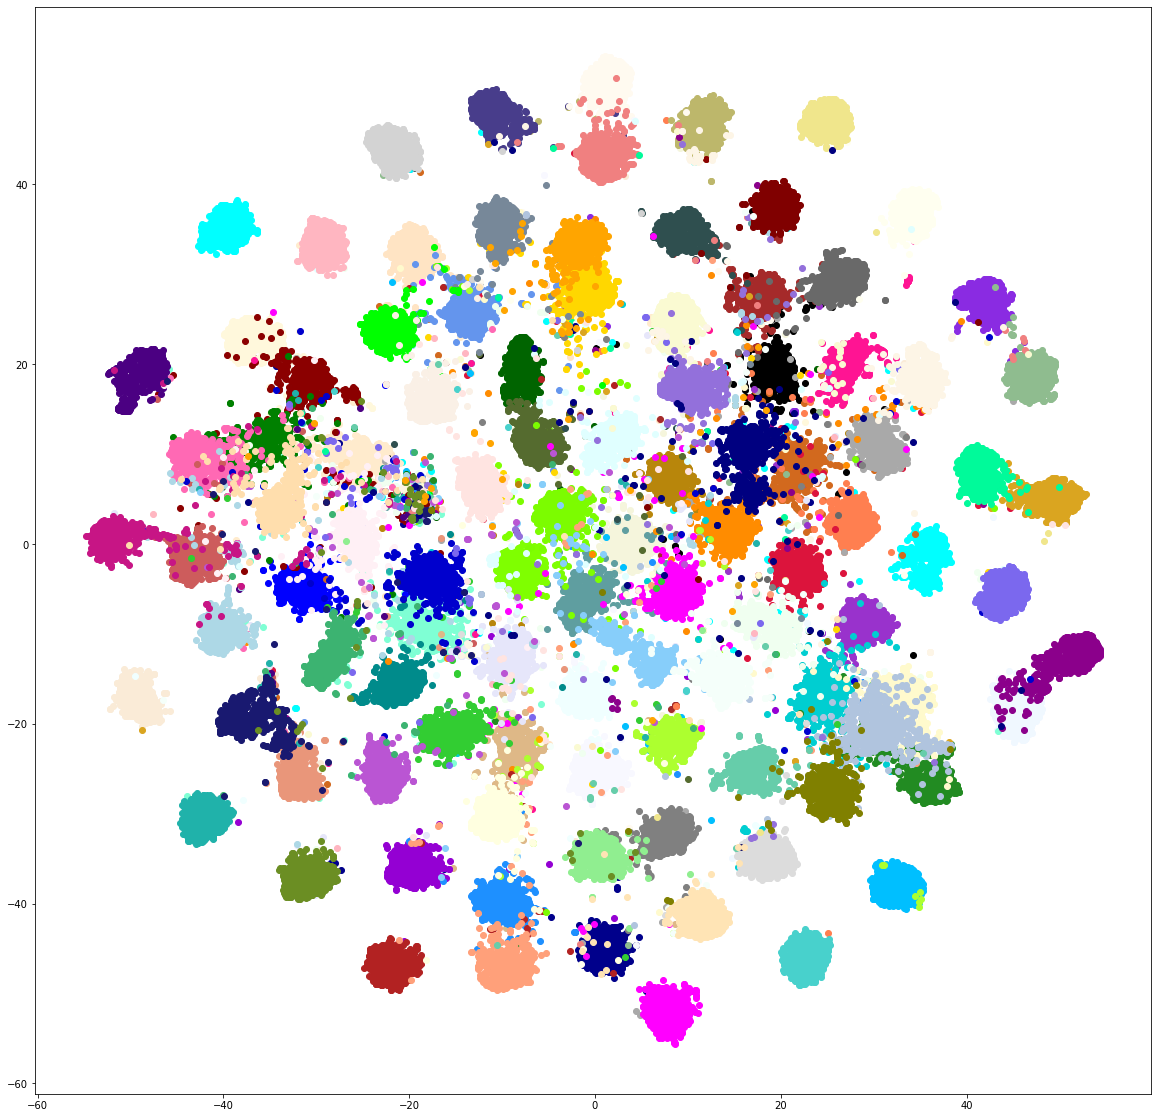

In [ ]:
target_ids = range(101)
filename = config.drive_dir + '/data/t-sne/' + 'basline_clean_tsne.png'

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
colors = color_nmes
for i, c, label in zip(target_ids, colors, list(set(y))):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
# plt.legend()
plt.savefig(filename)
plt.show()

### Plot Symmetric Noise

In [ ]:
  config.r = 0.9
  filename = config.drive_dir + '/data/' + 'noisy_label_kv'+str(int(config.r*100))+'_sim.txt'
  df_noise = pd.read_csv(filename, sep=' ', header = None)
  df_noise.columns = ["image","noisy_label"]
  df_noise.head(30)

,image,noisy_label
0,/images/apple_pie/1350394.jpg,49
1,/images/apple_pie/1354215.jpg,97
2,/images/apple_pie/1355206.jpg,53
3,/images/apple_pie/1357950.jpg,5
4,/images/apple_pie/1361950.jpg,33
5,/images/apple_pie/136256.jpg,65
6,/images/apple_pie/1376013.jpg,62
7,/images/apple_pie/1379062.jpg,51
8,/images/apple_pie/1391393.jpg,3
9,/images/apple_pie/1392703.jpg,38


In [ ]:
dict_mapping = df_noise.set_index("image").to_dict()['noisy_label']
DF_FULL["noisy_label"] = [dict_mapping[x] for x in DF_FULL.path] 
DF_FULL

,targets,path,feats,noisy_label
0,49,/images/sushi/794736.jpg,"[0.997857391834259, 0.7289683222770691, 0.1160...",49
1,75,/images/club_sandwich/2438386.jpg,"[0.26388218998908997, 0.6876015663146973, 0.16...",57
2,56,/images/macarons/2237879.jpg,"[0.2286073863506317, 0.06287682801485062, 0.07...",7
3,95,/images/ravioli/3524550.jpg,"[0.3628886342048645, 0.10507843643426895, 0.01...",96
4,17,/images/beet_salad/1384585.jpg,"[0.026511969044804573, 0.3093997538089752, 0.0...",98
...,...,...,...,...
68170,90,/images/donuts/328708.jpg,"[0.24955493211746216, 0.308126837015152, 0.107...",90
68171,41,/images/hamburger/1979079.jpg,"[0.05851959064602852, 0.5750203132629395, 0.23...",62
68172,3,/images/apple_pie/934503.jpg,"[0.03205859661102295, 0.2530951201915741, 0.36...",12
68173,67,/images/onion_rings/647116.jpg,"[0.12448088079690933, 0.7858483195304871, 0.16...",45


In [ ]:
y = DF_FULL.noisy_label

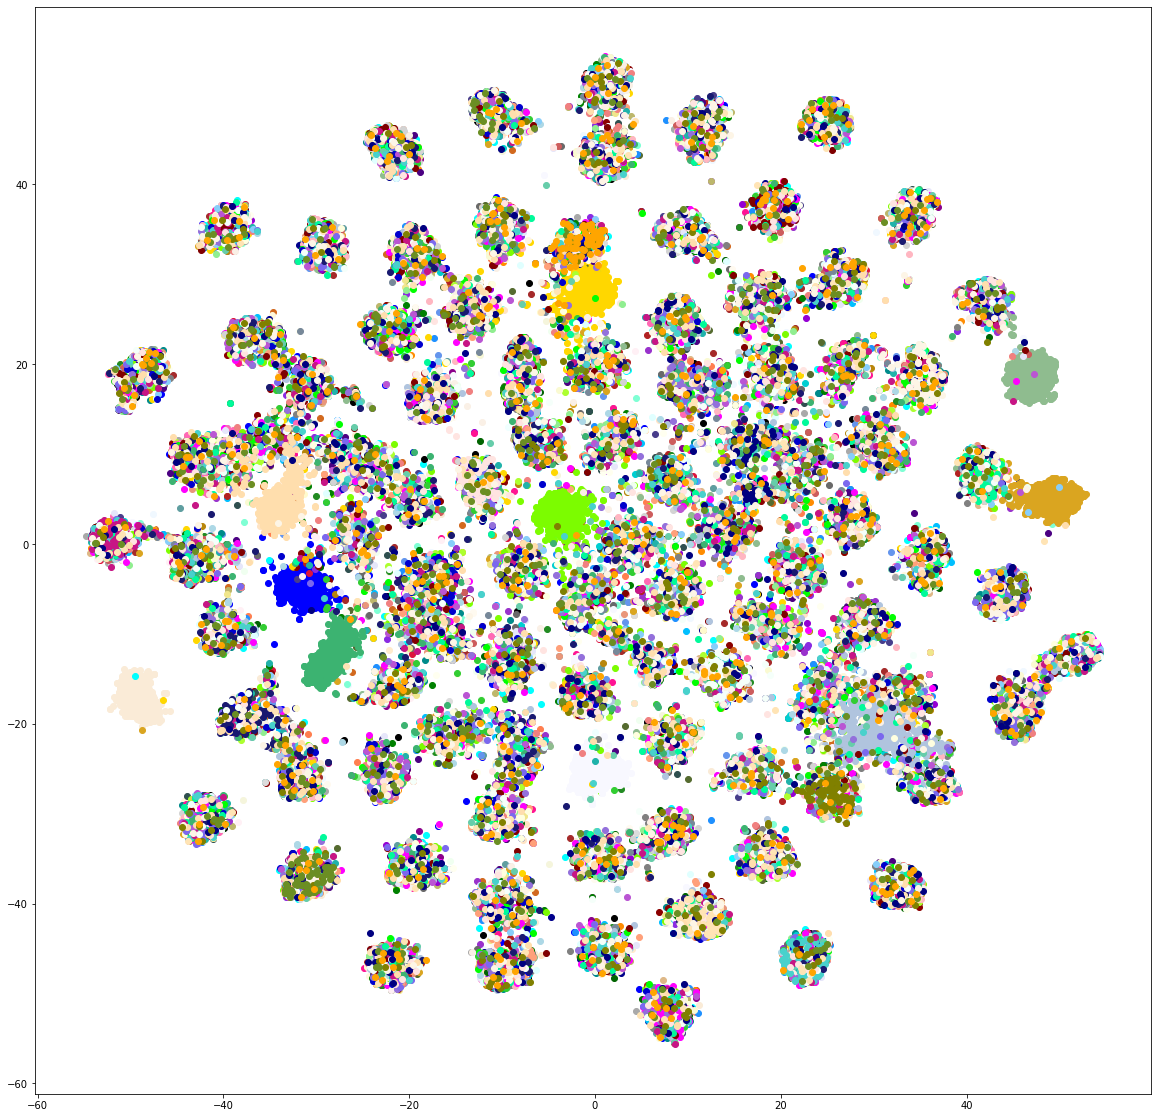

In [ ]:
target_ids = range(101)
filename = config.drive_dir + '/data/t-sne/' + 'basline_noise' + str(int(config.r*100)) +'_tsne.png'

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
colors = color_nmes
for i, c, label in zip(target_ids, colors, list(set(y))):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
# plt.legend()
plt.savefig(filename)
plt.show()

In [ ]:
len(y)

75000

In [ ]:
X_2d

array([[ 50.8064003 ,   5.68802261],
       [ -9.3283062 , -32.4544754 ],
       [-50.60325623,  18.45575523],
       ...,
       [-14.55820751, -11.16547775],
       [ -0.29667968, -39.31245041],
       [ 28.67908478, -15.6101017 ]])

## Plot Relabeling

In [ ]:
  config.r = 0.3
  filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed_images.csv'
  df_image_resampling_total = pd.read_csv(filename, sep=';', header = None)
  df_image_resampling_total.columns = ["image","times relabeled"]
  df_image_resampling_total

,image,times relabeled
0,ice_cream/529464.jpg,5
1,creme_brulee/3020031.jpg,4
2,fried_rice/2973781.jpg,4
3,pork_chop/187321.jpg,4
4,steak/3209173.jpg,4
...,...,...
46898,escargots/1882342.jpg,0
46899,escargots/1884796.jpg,0
46900,escargots/1884944.jpg,0
46901,escargots/1885991.jpg,0


In [ ]:
DF_FULL.path = [x[8:] for x in DF_FULL.path]
DF_FULL

,targets,path,feats
0,49,sushi/794736.jpg,"[0.997857391834259, 0.7289683222770691, 0.1160..."
1,75,club_sandwich/2438386.jpg,"[0.26388218998908997, 0.6876015663146973, 0.16..."
2,56,macarons/2237879.jpg,"[0.2286073863506317, 0.06287682801485062, 0.07..."
3,95,ravioli/3524550.jpg,"[0.3628886342048645, 0.10507843643426895, 0.01..."
4,17,beet_salad/1384585.jpg,"[0.026511969044804573, 0.3093997538089752, 0.0..."
...,...,...,...
68170,90,donuts/328708.jpg,"[0.24955493211746216, 0.308126837015152, 0.107..."
68171,41,hamburger/1979079.jpg,"[0.05851959064602852, 0.5750203132629395, 0.23..."
68172,3,apple_pie/934503.jpg,"[0.03205859661102295, 0.2530951201915741, 0.36..."
68173,67,onion_rings/647116.jpg,"[0.12448088079690933, 0.7858483195304871, 0.16..."


In [ ]:
DF_FULL = DF_FULL.merge(df_image_resampling_total, how = 'left', left_on = "path", right_on = "image")

In [ ]:
DF_FULL["times relabeled"].fillna(0, inplace=True)

In [ ]:
DF_FULL

,targets,path,feats,image,times relabeled
0,49,sushi/794736.jpg,"[0.997857391834259, 0.7289683222770691, 0.1160...",NaN,0.0
1,75,club_sandwich/2438386.jpg,"[0.26388218998908997, 0.6876015663146973, 0.16...",club_sandwich/2438386.jpg,0.0
2,56,macarons/2237879.jpg,"[0.2286073863506317, 0.06287682801485062, 0.07...",macarons/2237879.jpg,0.0
3,95,ravioli/3524550.jpg,"[0.3628886342048645, 0.10507843643426895, 0.01...",NaN,0.0
4,17,beet_salad/1384585.jpg,"[0.026511969044804573, 0.3093997538089752, 0.0...",beet_salad/1384585.jpg,0.0
...,...,...,...,...,...
68170,90,donuts/328708.jpg,"[0.24955493211746216, 0.308126837015152, 0.107...",donuts/328708.jpg,0.0
68171,41,hamburger/1979079.jpg,"[0.05851959064602852, 0.5750203132629395, 0.23...",hamburger/1979079.jpg,0.0
68172,3,apple_pie/934503.jpg,"[0.03205859661102295, 0.2530951201915741, 0.36...",apple_pie/934503.jpg,0.0
68173,67,onion_rings/647116.jpg,"[0.12448088079690933, 0.7858483195304871, 0.16...",NaN,0.0


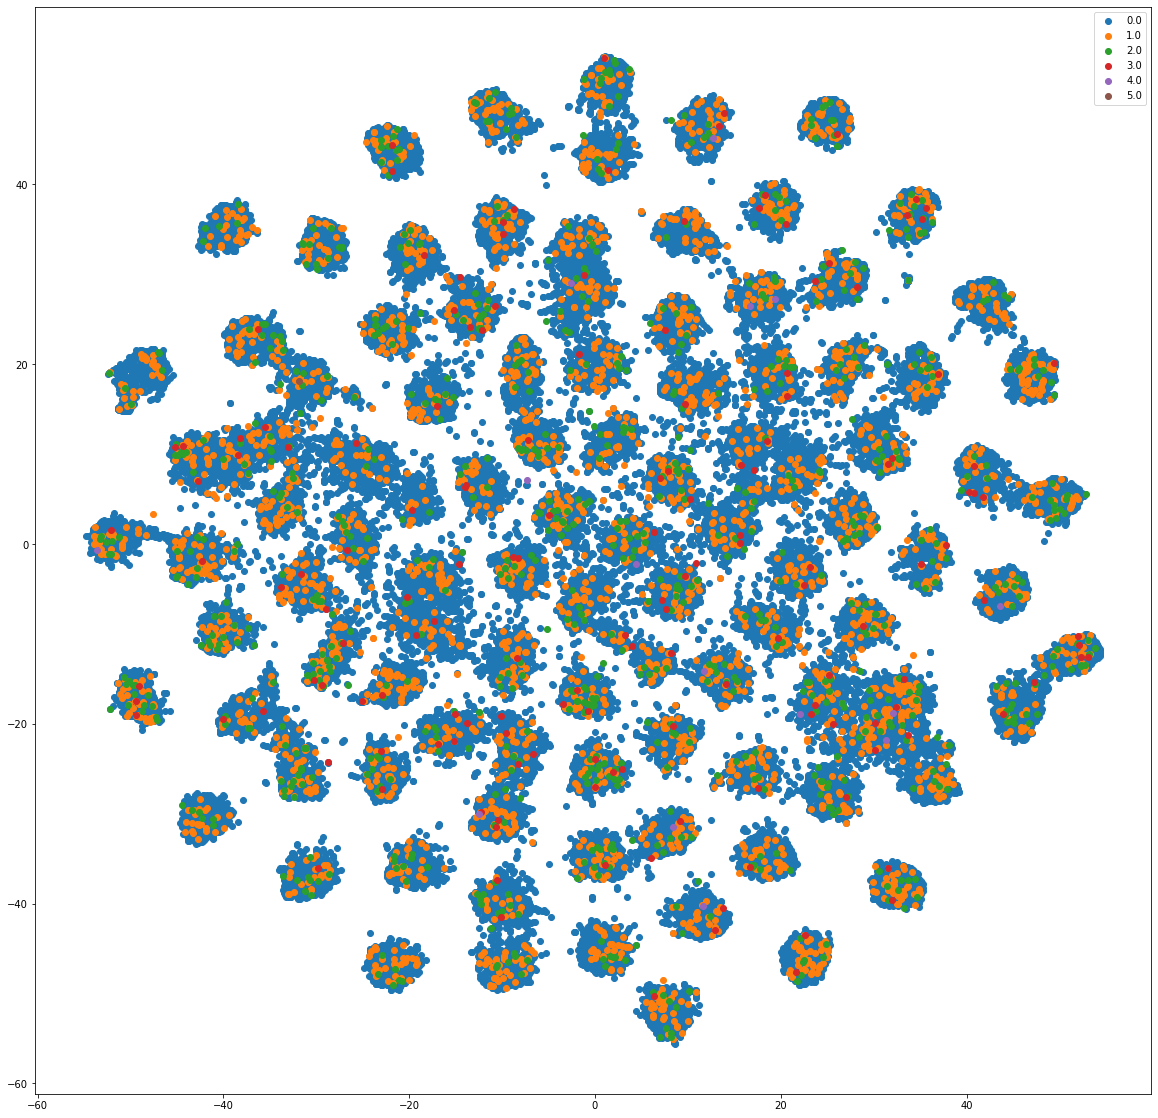

In [ ]:
target_ids = range(101)

y = DF_FULL["times relabeled"]

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
colors = color_nmes
for i, c, label in zip(target_ids, colors, list(set(y))):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=label)
plt.legend()
plt.show()

In [ ]:
colors

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgreen',
 'lightgray',
 'lightpink',
 'lightsalmon',
 'lights

In [ ]:
DF_FULL["times relabeled"] = [str(x) for x in DF_FULL["times relabeled"]]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green","green","forestgreen","lime","lime"])


No handles with labels found to put in legend.


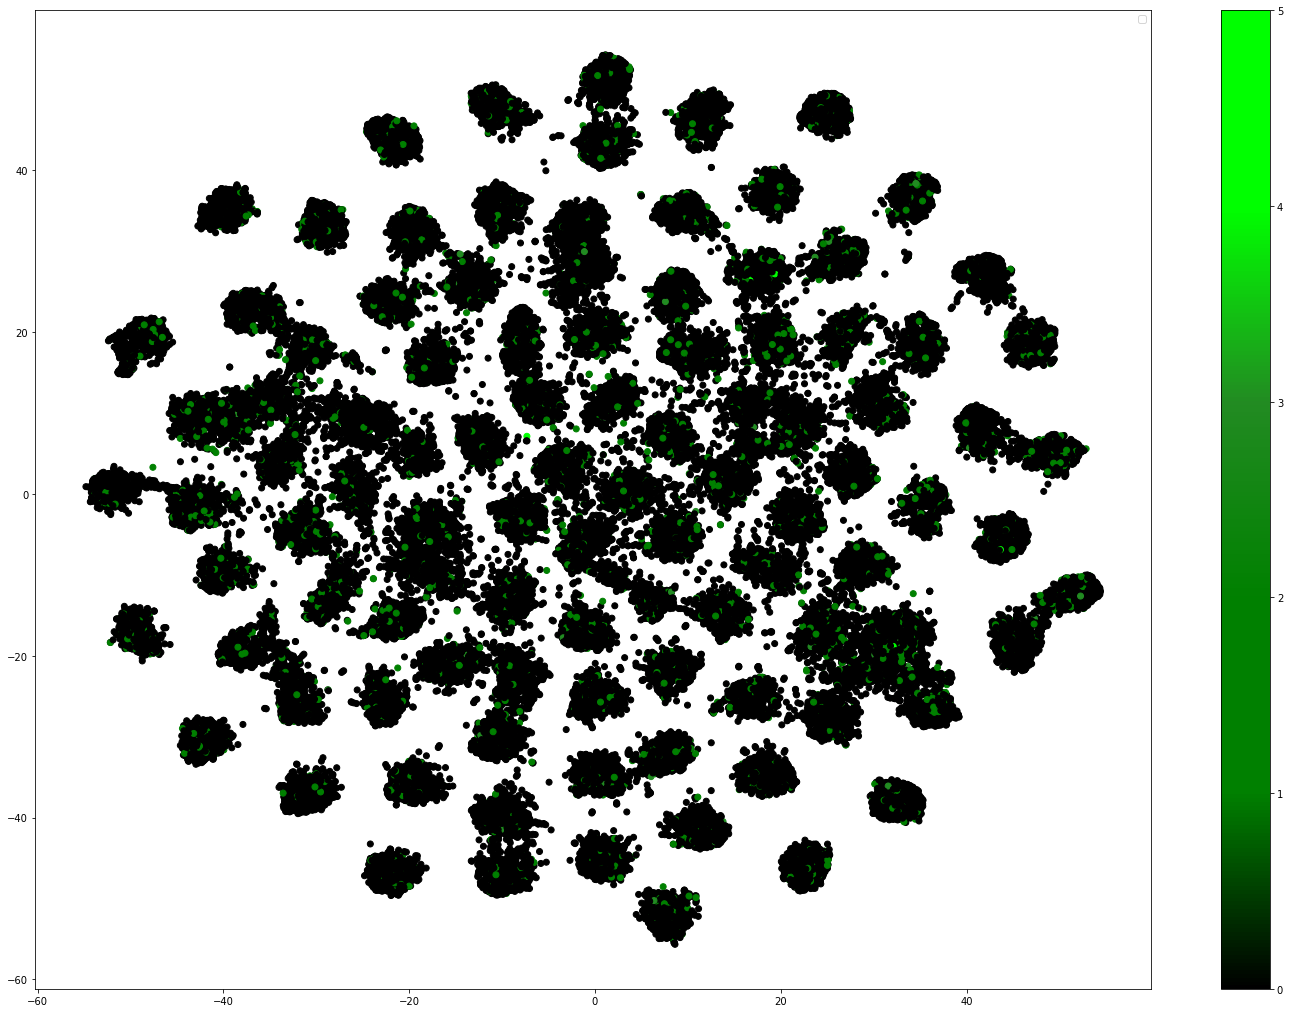

In [ ]:
target_ids = range(101)

y = DF_FULL["times relabeled"]

from matplotlib import pyplot as plt
plt.figure(figsize=(25, 18))


plt.scatter(X_2d[:, 0], X_2d[:, 1], c =  DF_FULL["times relabeled"], cmap = cmap)

plt.colorbar()


plt.legend()
plt.show()

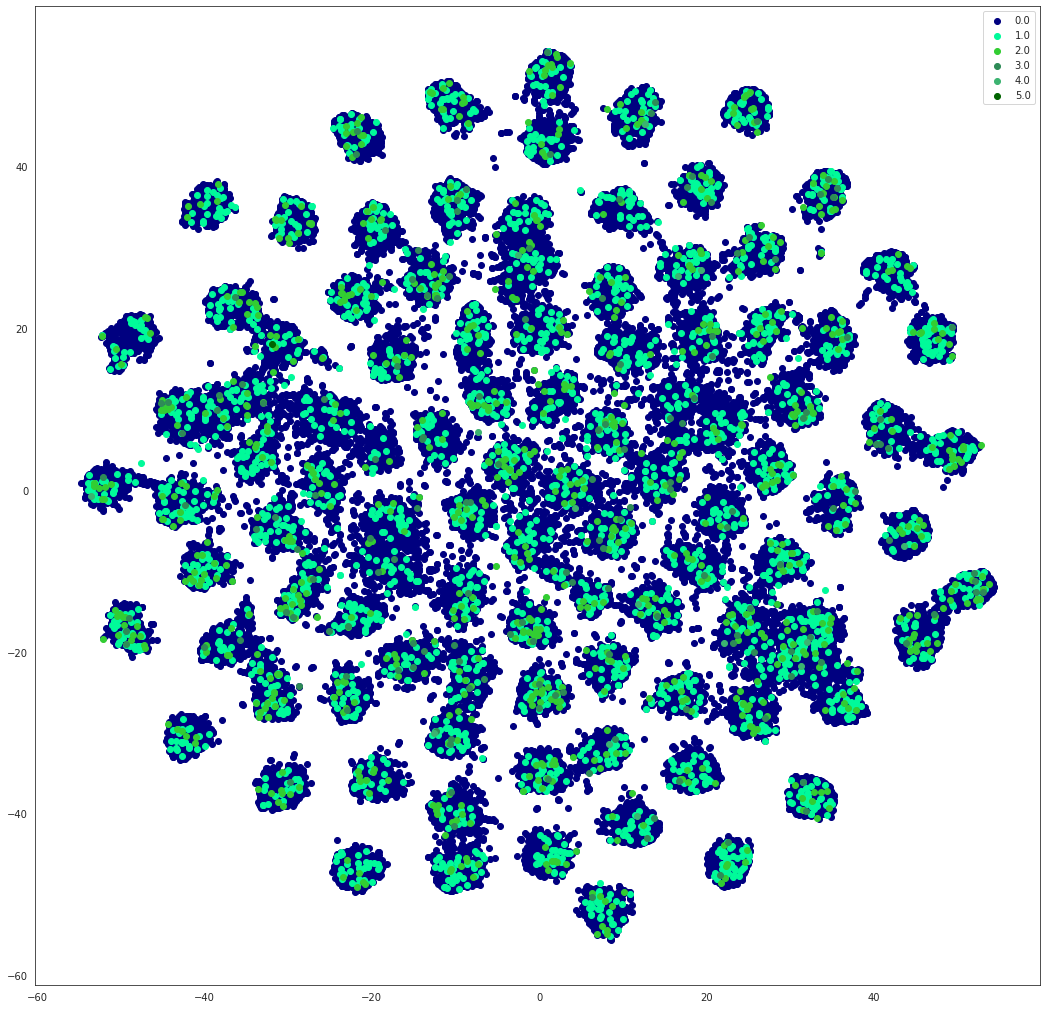

In [ ]:
target_ids = range(101)

y = DF_FULL["times relabeled"]

from matplotlib import pyplot as plt
plt.figure(figsize=(18, 18))
colors = ["navy","mediumspringgreen","limegreen","seagreen","mediumseagreen","darkgreen"]
for i, c, label in zip(target_ids, colors, list(set(y))):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c = c, label=label)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 8)
print(viridis)

In [ ]:
DF_FULL

,targets,path,feats,image,times relabeled
0,49,sushi/794736.jpg,"[0.997857391834259, 0.7289683222770691, 0.1160...",NaN,0.0
1,75,club_sandwich/2438386.jpg,"[0.26388218998908997, 0.6876015663146973, 0.16...",club_sandwich/2438386.jpg,0.0
2,56,macarons/2237879.jpg,"[0.2286073863506317, 0.06287682801485062, 0.07...",macarons/2237879.jpg,0.0
3,95,ravioli/3524550.jpg,"[0.3628886342048645, 0.10507843643426895, 0.01...",NaN,0.0
4,17,beet_salad/1384585.jpg,"[0.026511969044804573, 0.3093997538089752, 0.0...",beet_salad/1384585.jpg,0.0
...,...,...,...,...,...
68170,90,donuts/328708.jpg,"[0.24955493211746216, 0.308126837015152, 0.107...",donuts/328708.jpg,0.0
68171,41,hamburger/1979079.jpg,"[0.05851959064602852, 0.5750203132629395, 0.23...",hamburger/1979079.jpg,0.0
68172,3,apple_pie/934503.jpg,"[0.03205859661102295, 0.2530951201915741, 0.36...",apple_pie/934503.jpg,0.0
68173,67,onion_rings/647116.jpg,"[0.12448088079690933, 0.7858483195304871, 0.16...",NaN,0.0
